# Introduction to XArray
> This tutorial introduces XArray, a Python library for working with labeled multidimensional arrays.

- toc: false 
- badges: true
- comments: true
- categories: [xarray]

#### DEA uses XArray as its data model. To better understand what it is, let's first do a simple experiment on how we could pack remote sensing data using a combination of plain numpy arrays and Python dictionaries.

#### Suposse we have a satellite image with three bands: Red, NIR and SWIR. These bands are represented as 2-dimensional numpy arrays. We could also store the latitude and longitude coordinates for each dimension using 1-dimensional arrays. Finally, we could also store some metadata to help describe our images.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from check_answer import check_answer

red = np.random.rand(250,250)
nir = np.random.rand(250,250)
swir = np.random.rand(250,250)

lats = np.linspace(-23.5, -26.0, num=red.shape[0], endpoint=False)
lons = np.linspace(110.0, 112.5, num=red.shape[1], endpoint=False)

title = "Image of the desert"
date = "2019-11-10"

image = {"red": red,
         "nir": nir,
         "swir": swir,
         "latitude": lats,
         "longitude": lons,
         "title": title,
         "date": date}

#### All our data is conveniently packed in a dictionary. Now we can use this dictionary to work with it:

In [2]:
image["date"], image["latitude"][:4]

('2019-11-10', array([-23.5 , -23.51, -23.52, -23.53]))

#### We can address any variable inside this image dictionary and work directly with other functions. For example, to plot the nir band and calculate its mean:

0.49924875731405954

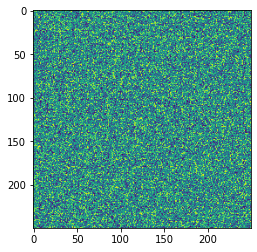

In [3]:
plt.imshow(image['nir'])

image["nir"].mean()

#### Still, the variables inside our dictionary are independent and we don't know how they are linked. For example, we have the variable `latitude` but we don't know to what axis in the image arrays it refers. We also need to use positional indices to select parts data in the numpy arrays containing the image data. Wouldn't it be convenient to be able to select data from the images using the coordinates of the pixels instead of their relative positions?

#### This is exactly what XArray solves! Let's see how it works:

In [4]:
import xarray as xr
from datetime import datetime

#### To explore XArray we have a file containing some reflectance data of Canberra that has been generated using the DEA library.

#### The object that we get `ds` is a XArray `Dataset`, which in some ways is very similar to the dictionary that we created before, but with lots of convenient functionality available.

In [5]:
ds = xr.open_dataset('data/canberra_ls8.nc')

ds

<xarray.Dataset>
Dimensions:    (latitude: 320, longitude: 320, time: 2)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01 2017-01-01
  * latitude   (latitude) float64 -35.34 -35.34 -35.34 ... -35.26 -35.26 -35.26
  * longitude  (longitude) float64 149.1 149.1 149.1 149.1 ... 149.2 149.2 149.2
Data variables:
    crs        int32 ...
    blue       (time, latitude, longitude) float32 ...
    green      (time, latitude, longitude) float32 ...
    red        (time, latitude, longitude) float32 ...
    nir        (time, latitude, longitude) float32 ...
    swir1      (time, latitude, longitude) float32 ...
    swir2      (time, latitude, longitude) float32 ...
Attributes:
    date_created:           2019-10-18T11:27:53.613700
    Conventions:            CF-1.6, ACDD-1.3
    history:                NetCDF-CF file created by datacube version '1.7+1...
    geospatial_bounds:      POLYGON ((149.08 -35.34,149.08 -35.26,149.16 -35....
    geospatial_bounds_crs:  EPSG:4326
    geospatial_lat_min:     -35.34
    geospatial_lat_max:     -35.26000000000001
    geospatial_lat_units:   degrees_north
    geospatial_lon_min:     149.08
    geospatial_lon_max:     149.16
    geospatial_lon_units:   degrees_east

#### A `Dataset` can be seen as a dictionary structure packing up the data, dimensions and attributes all linked together.

#### Variables in a `Dataset` object are called `DataArrays` and they share dimensions with the higher level `Dataset`

<img src="data/dataset-diagram.png" alt="drawing" width="600" align="left"/>

#### So far, we have been using 3-dimensional numpy arrays in which the third dimension represented the bands of images and remote sensing data. Numpy can store data in up to 32 dimensions so we could for example use 4-dimensional arrays to store multispectral images with a temporal dimensions, to perform time series analysis.

#### To facilitate working with these data, DEA follows the convention of storing spectral bands as separate variables storing each one as 3-dimensional cubes containing the temporal dimension.

#### To access a variable we can access as if it were a Python dictionary, or using the `.` notation, which is more convenient.

In [6]:
ds["green"]

#or alternatively 

ds.green

<xarray.DataArray 'green' (time: 2, latitude: 320, longitude: 320)>
[204800 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01 2017-01-01
  * latitude   (latitude) float64 -35.34 -35.34 -35.34 ... -35.26 -35.26 -35.26
  * longitude  (longitude) float64 149.1 149.1 149.1 149.1 ... 149.2 149.2 149.2
Attributes:
    grid_mapping:  crs
    units:         1

#### Dimensions are also stored as numerical arrays with the same size as the image's axis they are referring.

In [7]:
ds['time']

#or alternatively 

ds.time

<xarray.DataArray 'time' (time: 2)>
array(['2016-01-01T00:00:00.000000000', '2017-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2017-01-01
Attributes:
    standard_name:  time
    long_name:      Time, unix time-stamp
    axis:           T

#### Metadata is referred as Attributes and is internally stored under `.attrs`, but the same convenient `.` notation applies to them.

In [9]:
ds.attrs['Conventions']

#or alternatively 

ds.attrs

{'date_created': '2019-10-18T11:27:53.613700',
 'Conventions': 'CF-1.6, ACDD-1.3',
 'history': "NetCDF-CF file created by datacube version '1.7+128.gebdc898a.dirty' at 20191018.",
 'geospatial_bounds': 'POLYGON ((149.08 -35.34,149.08 -35.26,149.16 -35.26,149.16 -35.34,149.08 -35.34))',
 'geospatial_bounds_crs': 'EPSG:4326',
 'geospatial_lat_min': -35.34,
 'geospatial_lat_max': -35.26000000000001,
 'geospatial_lat_units': 'degrees_north',
 'geospatial_lon_min': 149.08,
 'geospatial_lon_max': 149.16,
 'geospatial_lon_units': 'degrees_east'}

#### Exercise 7.1: Can you access to the `geospatial_bounds_crs` value in the attributes of this XArray Dataset?

In [12]:
answ = ds.attrs['geospatial_bounds_crs']

print(answ)

check_answer("7.1", answ)

EPSG:4326


'Well done!'

#### DataArrays store their data internally as multidimensional numpy arrays. But these arrays contain dimensions or labels that make it easier handle the data. To access the underlaying numpy array of a `DataArray` we can use the `.values` notation.

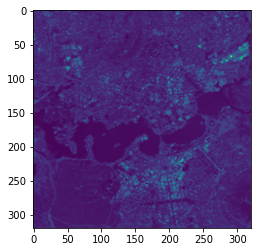

In [16]:
arr = ds.red.values

type(arr), arr.shape

plt.imshow(arr[0,:,:])

#### Exercise 7.2: Can you store in the `answ` variable the underlying numpy array containing the longitude dimension in this Dataset?

In [20]:
answ = ds.longitude.values

check_answer("7.2", int(answ[0]*1e6))

'Well done!'

#### Selecting data and subsetting numpy arrays is done using positional indices to specify positions or ranges of values along the different axis of an array. When we use the `[:,:]` notation, we need to know beforehand what is the relative position of each axis in our arrays.

#### XArray provides an abstraction in which we can refer to each axis by its name. Also we can select subsets of the data arrays using two modes or methods:

* `isel()`: For selecting data based on its index (like numpy).
* `sel()`: For selecting data based on its dimension of label value.

#### For example, for selecting the first element in the temporal dimension of the `green` variable we do:

In [23]:
print("Initial time dimension values:", ds.green.time.values)

ss = ds.green.isel(time=0)

ss

Initial time dimension values: ['2016-01-01T00:00:00.000000000' '2017-01-01T00:00:00.000000000']


<xarray.DataArray 'green' (latitude: 320, longitude: 320)>
array([[882., 911., 865., ..., 936., 925., 954.],
       [764., 872., 898., ..., 969., 969., 930.],
       [832., 897., 897., ..., 988., 901., 901.],
       ...,
       [618., 619., 607., ..., 966., 966., 965.],
       [591., 650., 708., ..., 895., 865., 521.],
       [582., 549., 549., ..., 889., 702., 456.]], dtype=float32)
Coordinates:
    time       datetime64[ns] 2016-01-01
  * latitude   (latitude) float64 -35.34 -35.34 -35.34 ... -35.26 -35.26 -35.26
  * longitude  (longitude) float64 149.1 149.1 149.1 149.1 ... 149.2 149.2 149.2
Attributes:
    grid_mapping:  crs
    units:         1

#### On the other hand we can use the `.sel()` method to select parts of the array by their label or content. See that in this case we do not refer to the data by its positional index but by its dimensional value.

In [28]:
#ss = ds.green.sel(time=datetime(2017,1,1))
ss = ds.green.sel(time="2017-01-01")

ss

<xarray.DataArray 'green' (latitude: 320, longitude: 320)>
array([[839., 861., 804., ..., 873., 868., 960.],
       [699., 813., 831., ..., 900., 900., 905.],
       [797., 889., 889., ..., 915., 863., 863.],
       ...,
       [642., 583., 589., ..., 970., 970., 986.],
       [625., 644., 681., ..., 894., 888., 546.],
       [554., 557., 557., ..., 878., 733., 436.]], dtype=float32)
Coordinates:
    time       datetime64[ns] 2017-01-01
  * latitude   (latitude) float64 -35.34 -35.34 -35.34 ... -35.26 -35.26 -35.26
  * longitude  (longitude) float64 149.1 149.1 149.1 149.1 ... 149.2 149.2 149.2
Attributes:
    grid_mapping:  crs
    units:         1

#### Both methods `sel()` and `isel()` can receive as many arguments as dimensions have the data array. We can use any order in to pass the dimensions and we can also define slices or ranges of values using the `slice()` notation. For example:

In [31]:
ss = ds.green.sel(time=datetime(2016,1,1), latitude=slice(-35.30,-35.24))

ss

<xarray.DataArray 'green' (latitude: 160, longitude: 320)>
array([[313., 313., 305., ..., 575., 413., 422.],
       [317., 316., 311., ..., 621., 476., 414.],
       [314., 318., 316., ..., 492., 492., 367.],
       ...,
       [618., 619., 607., ..., 966., 966., 965.],
       [591., 650., 708., ..., 895., 865., 521.],
       [582., 549., 549., ..., 889., 702., 456.]], dtype=float32)
Coordinates:
    time       datetime64[ns] 2016-01-01
  * latitude   (latitude) float64 -35.3 -35.3 -35.3 ... -35.26 -35.26 -35.26
  * longitude  (longitude) float64 149.1 149.1 149.1 149.1 ... 149.2 149.2 149.2
Attributes:
    grid_mapping:  crs
    units:         1

#### Exercise 7.3: Can you select the region of the red variable delimited by these coordinates:
* latitude [-35.30,-35.29]
* longitude [149.11,149.13]

In [33]:
print(ds.red.shape)
answ = ds.red.sel(longitude=slice(149.11,149.13), latitude=slice(-35.30,-35.29))
print(answ.shape)
check_answer("7.3", answ.shape)

(2, 320, 320)
(2, 40, 80)


'Well done!'

#### When we use the selection methods on Datasets and DataArrays we get an object of the same type.

In [35]:
ss = ds.sel(time=datetime(2016,1,1), latitude=slice(-35.30,-35.24))

type(ss), type(ds.green)

(xarray.core.dataset.Dataset, xarray.core.dataarray.DataArray)

#### Exercise 7.4: Use the `imshow` function to create an image of the first time of the red channel in the dataset.

> Tip: Use the `.values` method to convert the DataArray object into a numpy array, so matplotlib can work with it.

('Well done!',)

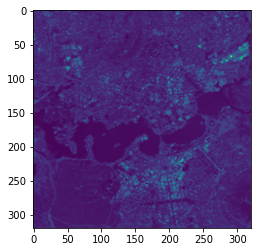

In [37]:
answ = ds.red.isel(time=0).values

plt.imshow(answ)

check_answer("7.4", int(answ[0,0])),

#### Xarray exposes lots of functions to perform analisis on `Datasets` and `DataArrays` with a similar syntax to numpy's. For example to calculate the spatial mean of the green band 

In [38]:
print("Mean of green band:", ds.green.mean())
print("Standard deviation of green band:", ds.green.std())
print("Sum of green band:", ds.green.sum())

Mean of green band: <xarray.DataArray 'green' ()>
array(692.3445, dtype=float32)
Standard deviation of green band: <xarray.DataArray 'green' ()>
array(313.6114502)
Sum of green band: <xarray.DataArray 'green' ()>
array(1.4179214e+08, dtype=float32)


#### Exercise 7.5: Can you find the difference between the means of the red and nir channels?

In [42]:
answ = ds.red.mean() - ds.nir.mean()

print(answ.values/10000)

check_answer("7.5", int(answ.values))

-0.1439588623046875


'Well done!'

#### Plotting is also conveniently integrated as a method on DataArrays.

> Note: For plotting you need to pass a 2-dimensional DataArray object, so normally a temporal element needs to be selected.

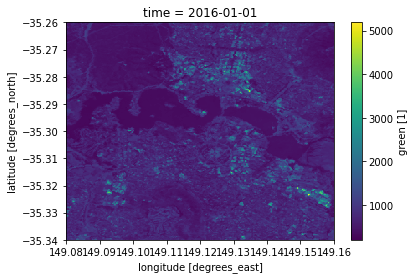

In [43]:
ds.green.isel(time=0).plot()

#### We still can do things manually using numpy and matplotlib

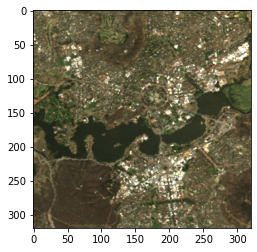

In [44]:
rgb = np.dstack((ds.red.isel(time=0).values, ds.green.isel(time=0).values, ds.blue.isel(time=0).values))
rgb = np.clip(rgb, 0, 2000) / 2000

plt.imshow(rgb)

#### The previous image is upside down, so we'd still need to flip the image vertically in numpy to represent it correctly. This has to do with how numerical arrays are stored in netCDF files.

#### But compare to these chained operations within XArray (Well see more simple ways of doing this in DEA though)

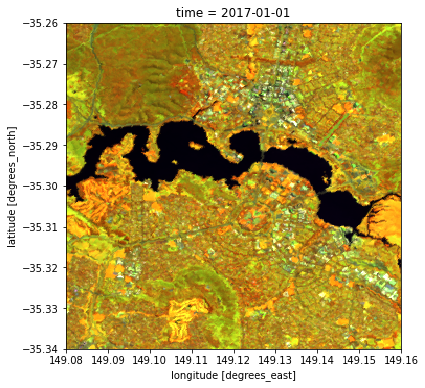

In [49]:
#   Selection of the bands  | time sel  | numpy conv|    plot   (params for plotting function)

ds[['nir', 'swir1', 'blue']].isel(time=1).to_array().plot.imshow(robust=True, figsize=(6, 6))

#### Exercise 7.6: Similarly to the previous image, create an RGB image using the `.sel()` functionality select the subset defined by the following dimension values:

* time -> 2017-01-01
* latitude -> [-35.29, -35.27]
* longitude -> [149.1, 149.13]

'Well done!'

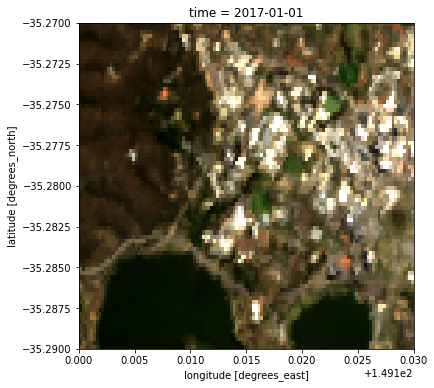

In [52]:
answ = ds[['red', 'green', 'blue']].sel(time="2017-01-01", latitude=slice(-35.29, -35.27), longitude=slice(149.1, 149.13))

answ.to_array().plot.imshow(robust=True, figsize=(6, 6))

check_answer("7.6", answ.to_array().values.shape)

#### Exercise 7.7: Can you create an NDVI representation of the whole extend in `ds`?

'Well done!'

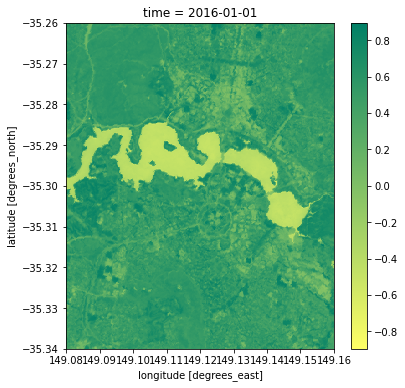

In [54]:
#NDVI = (rNIR - rRed) / (rNIR + rRed)

answ = (ds.nir - ds.red) / (ds.nir + ds.red)

answ.isel(time=0).plot(figsize=(6, 6), cmap='summer_r')

check_answer("7.7", int(answ.values[0,100,100]*1000))